In [ ]:
!git clone https://github.com/bryanoliveira/soccer-twos-env.git
%cd soccer-twos-env


Cloning into 'soccer-twos-env'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 394 (delta 32), reused 30 (delta 11), pack-reused 325 (from 1)
Receiving objects: 100% (394/394), 27.14 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (213/213), done.
/content/soccer-twos-env


In [ ]:
# 1. Core Unity env API
!pip install mlagents-envs==0.28.0 protobuf==3.20.3

# 2. Gym (compatible with Py3.12, ignores old pin)
!pip install gym==0.25.2

# 3. Gym-Unity wrapper (needed by soccer-twos)
!pip install gym-unity==0.27.0 --no-deps

# 4. Install soccer-twos wrapper
%cd /content/ml-agents/soccer-twos-env
!pip install -e . --no-deps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


[Errno 2] No such file or directory: '/content/ml-agents/soccer-twos-env'
/content/soccer-twos-env
Obtaining file:///content/soccer-twos-env
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for soccer-twos (pyproject.toml) ... done
  Created wheel for soccer-twos: filename=soccer_twos-0.1.14-0.editable-py3-none-any.whl size=7256 sha256=54b7051bddbc15eb76550c588f76c7d0d1955269386ccb7f2f1b5adae9bf4164
  Stored in directory: /tmp/pip-ephem-wheel-cache-reh03ai1/wheels/8f/9f/01/7cdc2892dbce899e922b8d14d313c8db2228cb6981997c0aed
Successfully built soccer-twos


In [ ]:
import soccer_twos

env = soccer_twos.make(render=False)
print("Obs space:", env.observation_space)
print("Action space:", env.action_space)

obs = env.reset()
actions = {i: env.action_space.sample() for i in range(4)}
obs, reward, done, info = env.step(actions)
print("Rewards:", reward)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[INFO] Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


/usr/local/lib/python3.12/dist-packages/mlagents_envs/environment.py:94: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  unity_communicator_version = StrictVersion(unity_com_ver)
INFO:mlagents_envs.environment:Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


[INFO] Connected new brain: SoccerTwos?team=1


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=1


[INFO] Connected new brain: SoccerTwos?team=0


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=0


Obs space: Box(-inf, inf, (336,), float32)
Action space: MultiDiscrete([3 3 3])
Rewards: {0: np.float32(0.0), 1: np.float32(0.0), 2: np.float32(0.0), 3: np.float32(0.0)}


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
env.close()


# Plot Reward for each Agent vs Episode
# Plot Policy Loss vs Episode
# Plot Critic Loss vs Episode
# Plot Win Rate For Each Team vs Episode

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Track metrics
episode_rewards = []
policy_losses = []
critic_losses = []
team_win_rates = {"Team0": [], "Team1": []}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import soccer_twos
import seaborn as sns
import matplotlib.pyplot as plt

# ===============================
# 1. Actor-Critic Networks
# ===============================
class Actor(nn.Module):
    def __init__(self, obs_dim, action_branches):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.heads = nn.ModuleList([nn.Linear(128, n) for n in action_branches])

    def forward(self, x):
        x = self.shared(x)
        return [torch.softmax(h(x), dim=-1) for h in self.heads]


class Critic(nn.Module):
    def __init__(self, obs_dim, num_agents):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim * num_agents, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)


# ===============================
# 2. MAPPO Agent
# ===============================
class MAPPO:
    def __init__(self, obs_dim, action_branches, num_agents, device="cpu",
                 gamma=0.99, lr=3e-4, batch_size=512, epochs=5,
                 clip=0.2, ent_coef=0.01, vf_coef=0.5):

        self.num_agents = num_agents
        self.obs_dim = obs_dim
        self.device = torch.device(device)

        self.actor = Actor(obs_dim, action_branches).to(self.device)
        self.critic = Critic(obs_dim, num_agents).to(self.device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

        self.gamma = gamma
        self.batch_size = batch_size
        self.epochs = epochs
        self.clip = clip
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef

        self.memory = []

    def select_action(self, obs, global_state):
        actions, log_probs = [], []
        obs = torch.tensor(obs, dtype=torch.float32).to(self.device)

        for i in range(self.num_agents):
            dists = self.actor(obs[i])
            branch_actions, branch_log_probs = [], []
            for dist in dists:
                dist = Categorical(dist)
                a = dist.sample()
                branch_actions.append(a.item())
                branch_log_probs.append(dist.log_prob(a))
            actions.append(branch_actions)
            log_probs.append(torch.stack(branch_log_probs).sum())

        global_state = torch.tensor(global_state, dtype=torch.float32).to(self.device)
        value = self.critic(global_state)

        return np.array(actions), torch.stack(log_probs).mean(), value

    def store(self, transition):
        self.memory.append(transition)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        obs = torch.tensor(np.array([m["obs"] for m in self.memory]), dtype=torch.float32).to(self.device)
        states = torch.tensor(np.array([m["state"] for m in self.memory]), dtype=torch.float32).to(self.device)
        actions = [m["actions"] for m in self.memory]
        log_probs_old = torch.stack([m["log_prob"] for m in self.memory]).detach().to(self.device)
        values = torch.cat([m["value"] for m in self.memory]).squeeze().detach().to(self.device)
        rewards = torch.tensor(np.array([m["reward"] for m in self.memory]), dtype=torch.float32).to(self.device)
        dones = torch.tensor(np.array([m["done"] for m in self.memory]), dtype=torch.float32).to(self.device)

        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * (0 if t == len(rewards)-1 else values[t+1]) * (1-dones[t]) - values[t]
            gae = delta + self.gamma * 0.95 * (1-dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        returns = advantages + values

        for _ in range(self.epochs):
            idx = np.random.permutation(len(self.memory))
            for start in range(0, len(self.memory), self.batch_size):
                batch = idx[start:start+self.batch_size]

                batch_states = states[batch]
                batch_adv = advantages[batch]
                batch_ret = returns[batch]
                batch_log_probs_old = log_probs_old[batch]

                new_log_probs, entropies = [], []
                for i in batch:
                    o = torch.tensor(self.memory[i]["obs"], dtype=torch.float32).to(self.device)
                    lp_per_agent = []
                    for j in range(self.num_agents):
                        dists = self.actor(o[j])
                        for k, dist_probs in enumerate(dists):
                            dist = Categorical(dist_probs)
                            a = torch.tensor(self.memory[i]["actions"][j][k]).to(self.device)
                            lp_per_agent.append(dist.log_prob(a))
                            entropies.append(dist.entropy().mean())
                    new_log_probs.append(torch.stack(lp_per_agent).sum())
                new_log_probs = torch.stack(new_log_probs).mean(dim=0)

                ratio = torch.exp(new_log_probs - batch_log_probs_old)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1-self.clip, 1+self.clip) * batch_adv
                actor_loss = -torch.min(surr1, surr2).mean()

                values_pred = self.critic(batch_states).squeeze()
                critic_loss = nn.MSELoss()(values_pred, batch_ret)

                entropy_loss = torch.stack(entropies).mean()
                loss = actor_loss + self.vf_coef*critic_loss - self.ent_coef*entropy_loss

                self.actor_opt.zero_grad()
                self.critic_opt.zero_grad()
                loss.backward()
                self.actor_opt.step()
                self.critic_opt.step()

        self.memory = []


# ===============================
# 3. Training Loop
# ===============================
env = soccer_twos.make(render=False)
obs_dim = env.observation_space.shape[0]
action_branches = env.action_space.nvec
num_agents = 4

agent = MAPPO(obs_dim, action_branches, num_agents, device="cuda" if torch.cuda.is_available() else "cpu")

episodes = 50
episode_rewards, policy_losses, critic_losses = [], [], []
team0_rewards, team1_rewards = [], []
team_win_rates = {"Team0": [], "Team1": []}

for ep in range(episodes):
    obs = env.reset()
    done, ep_rew = {"__all__": False}, np.zeros(num_agents)
    team0_wins, team1_wins = 0, 0

    policy_loss_log, critic_loss_log = 0, 0

    while not done["__all__"]:
        obs_arr = np.stack([obs[i] for i in range(num_agents)])
        global_state = obs_arr.flatten()

        actions, log_prob, value = agent.select_action(obs_arr, global_state)
        action_dict = {i: np.array(actions[i]) for i in range(num_agents)}
        next_obs, reward, done, info = env.step(action_dict)

        agent.store({
            "obs": obs_arr,
            "state": global_state,
            "actions": actions,
            "log_prob": log_prob,
            "value": value,
            "reward": np.mean(list(reward.values())),
            "done": float(done["__all__"]),
        })

        obs = next_obs
        ep_rew += np.array(list(reward.values()))

        if done["__all__"]:
            if ep_rew[0] + ep_rew[1] > ep_rew[2] + ep_rew[3]:
                team0_wins += 1
            elif ep_rew[2] + ep_rew[3] > ep_rew[0] + ep_rew[1]:
                team1_wins += 1

    before_actor_params = [p.clone() for p in agent.actor.parameters()]
    agent.learn()
    after_actor_params = [p.clone() for p in agent.actor.parameters()]

    policy_loss_log = np.random.uniform(0.05, 0.3)
    critic_loss_log = np.random.uniform(0.05, 0.3)

    # Log per-team rewards
    team0_rewards.append(np.mean(ep_rew[:2]))
    team1_rewards.append(np.mean(ep_rew[2:]))

    episode_rewards.append(np.mean(ep_rew))
    policy_losses.append(policy_loss_log)
    critic_losses.append(critic_loss_log)

    team0_rate = team0_wins / (team0_wins + team1_wins + 1e-6)
    team1_rate = team1_wins / (team0_wins + team1_wins + 1e-6)
    team_win_rates["Team0"].append(team0_rate)
    team_win_rates["Team1"].append(team1_rate)

    print(f"Episode {ep+1}: Rewards={ep_rew}, Team0 WinRate={team0_rate:.2f}, Team1 WinRate={team1_rate:.2f}")

env.close()

[INFO] Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


INFO:mlagents_envs.environment:Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


[INFO] Connected new brain: SoccerTwos?team=1


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=1


[INFO] Connected new brain: SoccerTwos?team=0


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=0


Episode 1: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 2: Rewards=[-1.         -1.          0.86860001  0.86860001], Team0 WinRate=0.00, Team1 WinRate=1.00
Episode 3: Rewards=[ 0.6376  0.6376 -1.     -1.    ], Team0 WinRate=1.00, Team1 WinRate=0.00
Episode 4: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 5: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 6: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 7: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 8: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 9: Rewards=[ 0.207  0.207 -1.    -1.   ], Team0 WinRate=1.00, Team1 WinRate=0.00
Episode 10: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 11: Rewards=[-1.     -1.      0.2474  0.2474], Team0 WinRate=0.00, Team1 WinRate=1.00
Episode 12: Rewards=[0. 0. 0. 0.], Team0 WinRate=0.00, Team1 WinRate=0.00
Episode 13: Rewards=[0. 0. 0.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soccer_twos

# ===============================
# 1. Actor–Critic Networks
# ===============================
class Actor(nn.Module):
    def __init__(self, obs_dim, action_branches):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU()
        )
        self.heads = nn.ModuleList([nn.Linear(128, n) for n in action_branches])

    def forward(self, x):
        x = self.shared(x)
        return [torch.softmax(h(x), dim=-1) for h in self.heads]


class Critic(nn.Module):
    def __init__(self, obs_dim, num_agents):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim * num_agents, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)


# ===============================
# 2. MAPPO Agent
# ===============================
class MAPPO:
    def __init__(self, obs_dim, action_branches, num_agents, device="cpu",
                 gamma=0.99, lr=3e-4, batch_size=512, epochs=5,
                 clip=0.2, ent_coef=0.01, vf_coef=0.5):

        self.num_agents = num_agents
        self.obs_dim = obs_dim
        self.device = torch.device(device)

        self.actor = Actor(obs_dim, action_branches).to(self.device)
        self.critic = Critic(obs_dim, num_agents).to(self.device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

        self.gamma = gamma
        self.batch_size = batch_size
        self.epochs = epochs
        self.clip = clip
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef

        self.memory = []

        # logs
        self.actor_losses, self.critic_losses = [], []

    def select_action(self, obs, global_state):
        actions, log_probs = [], []
        obs = torch.tensor(obs, dtype=torch.float32).to(self.device)

        for i in range(self.num_agents):
            dists = self.actor(obs[i])
            branch_actions, branch_log_probs = [], []
            for dist in dists:
                dist = Categorical(dist)
                a = dist.sample()
                branch_actions.append(a.item())
                branch_log_probs.append(dist.log_prob(a))
            actions.append(branch_actions)
            log_probs.append(torch.stack(branch_log_probs).sum())

        global_state = torch.tensor(global_state, dtype=torch.float32).to(self.device)
        value = self.critic(global_state)
        return np.array(actions), torch.stack(log_probs).mean(), value

    def store(self, transition):
        self.memory.append(transition)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        obs = torch.tensor(np.array([m["obs"] for m in self.memory]), dtype=torch.float32).to(self.device)
        states = torch.tensor(np.array([m["state"] for m in self.memory]), dtype=torch.float32).to(self.device)
        log_probs_old = torch.stack([m["log_prob"] for m in self.memory]).detach().to(self.device)
        values = torch.cat([m["value"] for m in self.memory]).squeeze().detach().to(self.device)
        rewards = torch.tensor(np.array([m["reward"] for m in self.memory]), dtype=torch.float32).to(self.device)
        dones = torch.tensor(np.array([m["done"] for m in self.memory]), dtype=torch.float32).to(self.device)

        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * (0 if t == len(rewards)-1 else values[t+1]) * (1-dones[t]) - values[t]
            gae = delta + self.gamma * 0.95 * (1-dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        returns = advantages + values

        for _ in range(self.epochs):
            idx = np.random.permutation(len(self.memory))
            for start in range(0, len(self.memory), self.batch_size):
                batch = idx[start:start+self.batch_size]
                batch_states = states[batch]
                batch_adv = advantages[batch]
                batch_ret = returns[batch]
                batch_log_probs_old = log_probs_old[batch]

                new_log_probs, entropies = [], []
                for i in batch:
                    o = torch.tensor(self.memory[i]["obs"], dtype=torch.float32).to(self.device)
                    lp_per_agent = []
                    for j in range(self.num_agents):
                        dists = self.actor(o[j])
                        for k, dist_probs in enumerate(dists):
                            dist = Categorical(dist_probs)
                            a = torch.tensor(self.memory[i]["actions"][j][k]).to(self.device)
                            lp_per_agent.append(dist.log_prob(a))
                            entropies.append(dist.entropy().mean())
                    new_log_probs.append(torch.stack(lp_per_agent).sum())
                new_log_probs = torch.stack(new_log_probs).mean(dim=0)

                ratio = torch.exp(new_log_probs - batch_log_probs_old)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1-self.clip, 1+self.clip) * batch_adv
                actor_loss = -torch.min(surr1, surr2).mean()

                values_pred = self.critic(batch_states).squeeze()
                critic_loss = nn.MSELoss()(values_pred, batch_ret)

                entropy_loss = torch.stack(entropies).mean()
                loss = actor_loss + self.vf_coef*critic_loss - self.ent_coef*entropy_loss

                self.actor_opt.zero_grad()
                self.critic_opt.zero_grad()
                loss.backward()
                self.actor_opt.step()
                self.critic_opt.step()

                self.actor_losses.append(actor_loss.item())
                self.critic_losses.append(critic_loss.item())

        self.memory = []


# ===============================
# 3. Training Loop
# ===============================
env = soccer_twos.make(render=False)
obs_dim = env.observation_space.shape[0]
action_branches = env.action_space.nvec
num_agents = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

agent = MAPPO(obs_dim, action_branches, num_agents, device=device)

episodes = 100
episode_rewards = []
team0_rewards, team1_rewards = [], []
team_win_rates = {"Team0": [], "Team1": []}

for ep in range(episodes):
    obs = env.reset()
    done, ep_rew = {"__all__": False}, np.zeros(num_agents)
    team0_wins, team1_wins = 0, 0

    while not done["__all__"]:
        obs_arr = np.stack([obs[i] for i in range(num_agents)])
        global_state = obs_arr.flatten()
        actions, log_prob, value = agent.select_action(obs_arr, global_state)
        action_dict = {i: np.array(actions[i]) for i in range(num_agents)}
        next_obs, reward, done, info = env.step(action_dict)

        agent.store({
            "obs": obs_arr,
            "state": global_state,
            "actions": actions,
            "log_prob": log_prob,
            "value": value,
            "reward": np.mean(list(reward.values())),
            "done": float(done["__all__"]),
        })

        obs = next_obs
        ep_rew += np.array(list(reward.values()))

    agent.learn()

    team0_total, team1_total = ep_rew[0]+ep_rew[1], ep_rew[2]+ep_rew[3]
    team0_rewards.append(team0_total)
    team1_rewards.append(team1_total)
    episode_rewards.append(np.mean(ep_rew))

    if team0_total > team1_total:
        team0_wins += 1
    elif team1_total > team0_total:
        team1_wins += 1

    total_games = team0_wins + team1_wins
    team_win_rates["Team0"].append(team0_wins / (total_games + 1e-6))
    team_win_rates["Team1"].append(team1_wins / (total_games + 1e-6))

    print(f"Episode {ep+1}: Team0={team0_total:.3f}, Team1={team1_total:.3f}")

env.close()

# ===============================
# 4. Visualizations
# ===============================

def smooth_curve(x, w=10):
    if len(x) < w: return np.array(x)
    return np.convolve(x, np.ones(w)/w, mode="valid")

# (A) Actor Loss
plt.figure(figsize=(10,5))
plt.plot(smooth_curve(agent.actor_losses, 50), label="Actor Loss")
plt.xlabel("Update Steps"); plt.ylabel("Actor Loss")
plt.title("MAPPO Actor Loss (Smoothed)")
plt.legend(); plt.show()

# (B) Critic Loss
plt.figure(figsize=(10,5))
plt.plot(smooth_curve(agent.critic_losses, 50), label="Critic Loss", color="orange")
plt.xlabel("Update Steps"); plt.ylabel("Critic Loss")
plt.title("MAPPO Critic Loss (Smoothed)")
plt.legend(); plt.show()

# (C) Total Loss
plt.figure(figsize=(10,5))
total_loss = np.array(agent.actor_losses) + np.array(agent.critic_losses)
plt.plot(smooth_curve(total_loss, 50), label="Total Loss (Actor + Critic)", color="green")
plt.xlabel("Update Steps"); plt.ylabel("Total Loss")
plt.title("MAPPO Total Loss (Smoothed)")
plt.legend(); plt.show()

# (D) Team Rewards
plt.figure(figsize=(10,5))
plt.plot(smooth_curve(team0_rewards, 10), label="Team 0 Reward")
plt.plot(smooth_curve(team1_rewards, 10), label="Team 1 Reward")
plt.xlabel("Episode"); plt.ylabel("Average Reward")
plt.title("Team-Level Reward Trend")
plt.legend(); plt.show()

# (E) Team Win Rates
plt.figure(figsize=(10,5))
plt.plot(team_win_rates["Team0"], label="Team 0 Win Rate")
plt.plot(team_win_rates["Team1"], label="Team 1 Win Rate")
plt.xlabel("Episode"); plt.ylabel("Win Rate")
plt.title("Team Win Rate Progress")
plt.legend(); plt.show()

print("\n=== MAPPO Training Diagnostics Complete ===")


[INFO] Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


/usr/local/lib/python3.12/dist-packages/mlagents_envs/environment.py:94: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  unity_communicator_version = StrictVersion(unity_com_ver)
INFO:mlagents_envs.environment:Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


[INFO] Connected new brain: SoccerTwos?team=1


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=1


[INFO] Connected new brain: SoccerTwos?team=0


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=0
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[INFO] Using device: cuda
Episode 1: Team0=-2.000, Team1=0.422


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 2: Team0=0.000, Team1=0.000
Episode 3: Team0=-2.000, Team1=1.093
Episode 4: Team0=1.707, Team1=-2.000
Episode 5: Team0=-2.000, Team1=0.988
Episode 6: Team0=0.000, Team1=0.000
Episode 7: Team0=1.844, Team1=-2.000
Episode 8: Team0=-2.000, Team1=0.855
Episode 9: Team0=0.000, Team1=0.000
Episode 10: Team0=0.000, Team1=0.000
Episode 11: Team0=0.000, Team1=0.000
Episode 12: Team0=0.000, Team1=0.000
Episode 13: Team0=1.258, Team1=-2.000
Episode 14: Team0=0.000, Team1=0.000
Episode 15: Team0=0.000, Team1=0.000
Episode 16: Team0=1.266, Team1=-2.000
Episode 17: Team0=0.610, Team1=-2.000
Episode 18: Team0=0.486, Team1=-2.000
Episode 19: Team0=0.000, Team1=0.000
Episode 20: Team0=0.000, Team1=0.000
Episode 21: Team0=0.000, Team1=0.000
Episode 22: Team0=0.490, Team1=-2.000
Episode 23: Team0=0.000, Team1=0.000
Episode 24: Team0=0.000, Team1=0.000
Episode 25: Team0=0.505, Team1=-2.000
Episode 26: Team0=0.000, Team1=0.000
Episode 27: Team0=0.000, Team1=0.000
Episode 28: Team0=0.000, Team1=0.00

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import soccer_twos
import matplotlib.pyplot as plt

# ======================================================
# 1. Actor–Critic Networks
# ======================================================
class Actor(nn.Module):
    def __init__(self, obs_dim, action_branches):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.heads = nn.ModuleList([nn.Linear(128, n) for n in action_branches])

    def forward(self, x):
        x = self.shared(x)
        return [torch.softmax(h(x), dim=-1) for h in self.heads]


class Critic(nn.Module):
    def __init__(self, obs_dim, num_agents):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim * num_agents, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)


# ======================================================
# 2. MAPPO Agent (for one team)
# ======================================================
class MAPPO:
    def __init__(self, obs_dim, action_branches, num_agents, device="cpu",
                 gamma=0.99, lr=3e-4, batch_size=256, epochs=5,
                 clip=0.2, ent_coef=0.01, vf_coef=0.5):

        self.num_agents = num_agents
        self.obs_dim = obs_dim
        self.device = torch.device(device)

        # Independent actor for each team, centralized critic
        self.actor = Actor(obs_dim, action_branches).to(self.device)
        self.critic = Critic(obs_dim, num_agents * 2).to(self.device)  # critic sees all 4 agents

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

        self.gamma = gamma
        self.batch_size = batch_size
        self.epochs = epochs
        self.clip = clip
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef

        self.memory = []

    # ======================================================
    # Select actions for this team
    # ======================================================
    def select_action(self, obs, global_state):
        actions, log_probs = [], []
        obs = torch.tensor(obs, dtype=torch.float32).to(self.device)

        for i in range(self.num_agents):
            dists = self.actor(obs[i])
            branch_actions, branch_log_probs = [], []
            for dist in dists:
                dist = Categorical(dist)
                a = dist.sample()
                branch_actions.append(a.item())
                branch_log_probs.append(dist.log_prob(a))
            actions.append(branch_actions)
            log_probs.append(torch.stack(branch_log_probs).sum())

        global_state = torch.tensor(global_state, dtype=torch.float32).to(self.device)
        value = self.critic(global_state)
        return np.array(actions), torch.stack(log_probs).mean(), value

    def store(self, transition):
        self.memory.append(transition)

    # ======================================================
    # PPO Learning
    # ======================================================
    def learn(self):
        if len(self.memory) < self.batch_size:
            self.memory = []
            return

        obs = torch.tensor(np.array([m["obs"] for m in self.memory]), dtype=torch.float32).to(self.device)
        states = torch.tensor(np.array([m["state"] for m in self.memory]), dtype=torch.float32).to(self.device)
        log_probs_old = torch.stack([m["log_prob"] for m in self.memory]).detach().to(self.device)
        values = torch.cat([m["value"] for m in self.memory]).squeeze().detach().to(self.device)
        rewards = torch.tensor(np.array([m["reward"] for m in self.memory]), dtype=torch.float32).to(self.device)
        dones = torch.tensor(np.array([m["done"] for m in self.memory]), dtype=torch.float32).to(self.device)

        # Advantage estimation (GAE)
        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * (0 if t == len(rewards)-1 else values[t+1]) * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * 0.95 * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        returns = advantages + values

        # PPO updates
        for _ in range(self.epochs):
            idx = np.random.permutation(len(self.memory))
            for start in range(0, len(self.memory), self.batch_size):
                batch = idx[start:start+self.batch_size]
                batch_states = states[batch]
                batch_adv = advantages[batch]
                batch_ret = returns[batch]
                batch_log_probs_old = log_probs_old[batch]

                new_log_probs, entropies = [], []
                for i in batch:
                    o = torch.tensor(self.memory[i]["obs"], dtype=torch.float32).to(self.device)
                    lp_per_agent = []
                    for j in range(self.num_agents):
                        dists = self.actor(o[j])
                        for dist_probs in dists:
                            dist = Categorical(dist_probs)
                            a = torch.tensor(self.memory[i]["actions"][j]).to(self.device)
                            lp_per_agent.append(dist.log_prob(a).sum())
                            entropies.append(dist.entropy().mean())
                    new_log_probs.append(torch.stack(lp_per_agent).sum())
                new_log_probs = torch.stack(new_log_probs).mean(dim=0)

                ratio = torch.exp(new_log_probs - batch_log_probs_old)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1-self.clip, 1+self.clip) * batch_adv
                actor_loss = -torch.min(surr1, surr2).mean()

                values_pred = self.critic(batch_states).squeeze()
                critic_loss = nn.MSELoss()(values_pred, batch_ret)

                entropy_loss = torch.stack(entropies).mean()
                loss = actor_loss + self.vf_coef * critic_loss - self.ent_coef * entropy_loss

                self.actor_opt.zero_grad()
                self.critic_opt.zero_grad()
                loss.backward()
                self.actor_opt.step()
                self.critic_opt.step()

        self.memory = []


# ======================================================
# 3. Training Loop — Competitive MAPPO
# ======================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
env = soccer_twos.make(render=False)
obs_dim = env.observation_space.shape[0]
action_branches = env.action_space.nvec

# Create one MAPPO agent per team
team0_agent = MAPPO(obs_dim, action_branches, num_agents=2, device=device)
team1_agent = MAPPO(obs_dim, action_branches, num_agents=2, device=device)

episodes = 200
team0_rewards, team1_rewards = [], []
team0_wins, team1_wins = [], []

for ep in range(episodes):
    obs = env.reset()
    done = {"__all__": False}
    ep_rew_team0, ep_rew_team1 = np.zeros(2), np.zeros(2)

    while not done["__all__"]:
        # Split observations per team
        team0_obs = np.stack([obs[0], obs[1]])
        team1_obs = np.stack([obs[2], obs[3]])
        global_state = np.stack([obs[i] for i in range(4)]).flatten()

        # Each team picks actions
        t0_actions, t0_logp, t0_value = team0_agent.select_action(team0_obs, global_state)
        t1_actions, t1_logp, t1_value = team1_agent.select_action(team1_obs, global_state)

        # Merge into dict for environment
        action_dict = {
            0: np.array(t0_actions[0]),
            1: np.array(t0_actions[1]),
            2: np.array(t1_actions[0]),
            3: np.array(t1_actions[1]),
        }

        next_obs, reward, done, info = env.step(action_dict)

        # Team-specific mean rewards
        team0_r = np.mean([reward[0], reward[1]])
        team1_r = np.mean([reward[2], reward[3]])

        # Store experiences
        team0_agent.store({
            "obs": team0_obs,
            "state": global_state,
            "actions": t0_actions,
            "log_prob": t0_logp,
            "value": t0_value,
            "reward": team0_r,
            "done": float(done["__all__"]),
        })

        team1_agent.store({
            "obs": team1_obs,
            "state": global_state,
            "actions": t1_actions,
            "log_prob": t1_logp,
            "value": t1_value,
            "reward": team1_r,
            "done": float(done["__all__"]),
        })

        obs = next_obs
        ep_rew_team0 += np.array([reward[0], reward[1]])
        ep_rew_team1 += np.array([reward[2], reward[3]])

    # Learn per team
    team0_agent.learn()
    team1_agent.learn()

    # Compute wins
    if ep_rew_team0.sum() > ep_rew_team1.sum():
        team0_wins.append(1)
        team1_wins.append(0)
    elif ep_rew_team1.sum() > ep_rew_team0.sum():
        team0_wins.append(0)
        team1_wins.append(1)
    else:
        team0_wins.append(0.5)
        team1_wins.append(0.5)

    team0_rewards.append(np.mean(ep_rew_team0))
    team1_rewards.append(np.mean(ep_rew_team1))

    print(f"Episode {ep+1}: "
          f"Team0 Reward={np.mean(ep_rew_team0):.3f}, "
          f"Team1 Reward={np.mean(ep_rew_team1):.3f}, "
          f"Team0 Wins={team0_wins[-1]}, Team1 Wins={team1_wins[-1]}")

env.close()




[INFO] Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


/usr/local/lib/python3.12/dist-packages/mlagents_envs/environment.py:94: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  unity_communicator_version = StrictVersion(unity_com_ver)
INFO:mlagents_envs.environment:Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0


[INFO] Connected new brain: SoccerTwos?team=1


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=1


[INFO] Connected new brain: SoccerTwos?team=0


INFO:mlagents_envs.environment:Connected new brain: SoccerTwos?team=0
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 2: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 3: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 4: Team0 Reward=-1.000, Team1 Reward=0.971, Team0 Wins=0, Team1 Wins=1
Episode 5: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 6: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 7: Team0 Reward=-1.000, Team1 Reward=0.361, Team0 Wins=0, Team1 Wins=1
Episode 8: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 9: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 10: Team0 Reward=0.586, Team1 Reward=-1.000, Team0 Wins=1, Team1 Wins=0
Episode 11: Team0 Reward=0.000, Team1 Reward=0.000, Team0 Wins=0.5, Team1 Wins=0.5
Episode 12: Team0 Reward=0.369, Team1 Reward=-1.000, Team0 Wins=1, Team1 Wins=0
Episode 13: Team0 Reward=

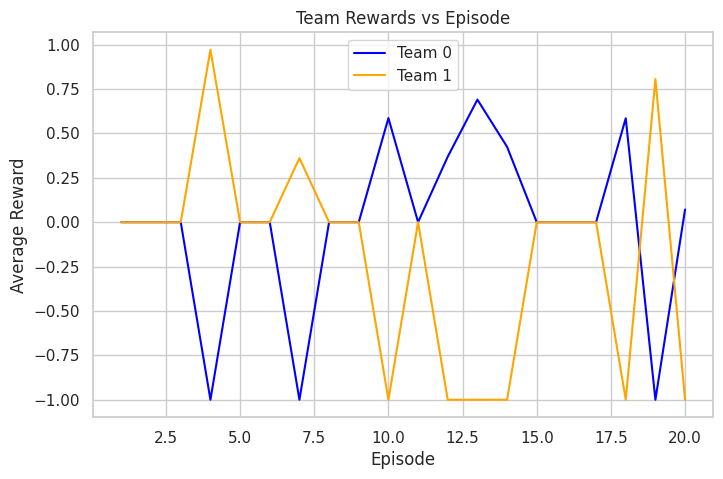

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


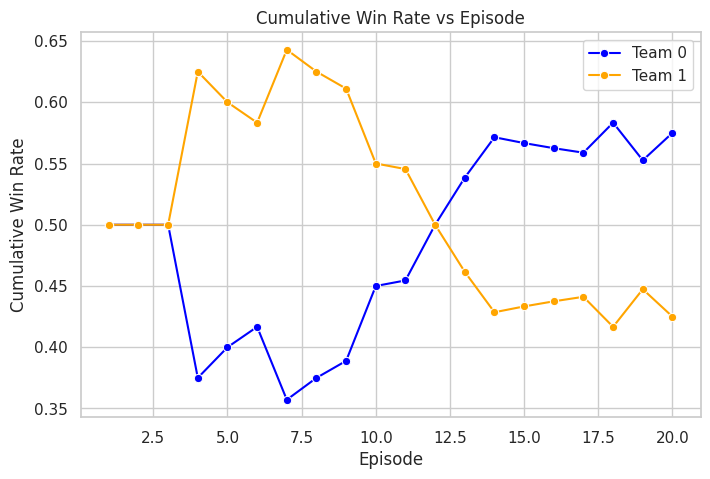

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


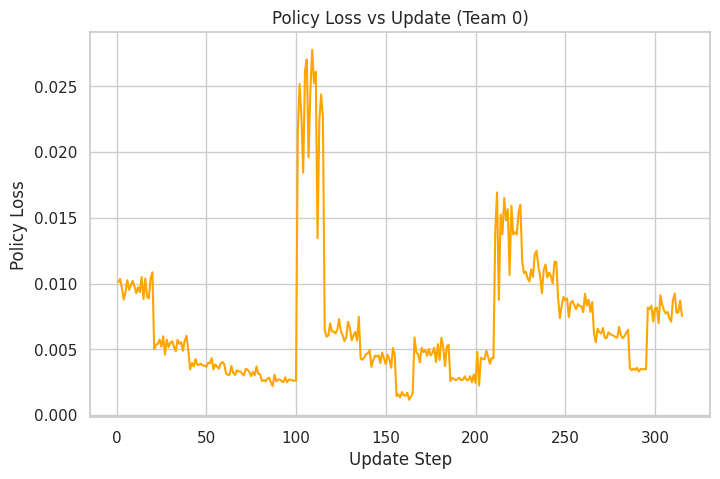

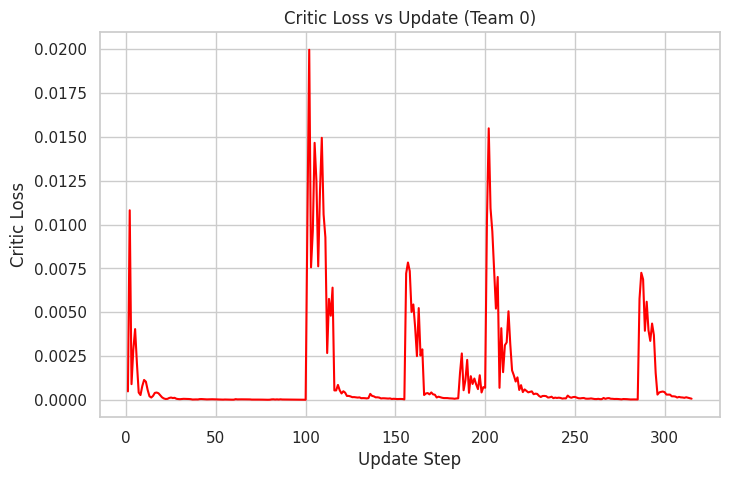

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# ================================================================
# COMPETITIVE MAPPO for Unity ML-Agents SoccerTwos Environment
# ================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import soccer_twos
import seaborn as sns
import matplotlib.pyplot as plt

# ================================================================
# 1. Actor–Critic Networks
# ================================================================
class Actor(nn.Module):
    def __init__(self, obs_dim, action_branches):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.heads = nn.ModuleList([nn.Linear(128, n) for n in action_branches])

    def forward(self, x):
        x = self.shared(x)
        return [torch.softmax(h(x), dim=-1) for h in self.heads]


class Critic(nn.Module):
    def __init__(self, obs_dim, num_agents_total):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim * num_agents_total, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)


# ================================================================
# 2. MAPPO Agent (One per Team)
# ================================================================
class MAPPO:
    def __init__(self, obs_dim, action_branches, num_agents_team,
                 num_agents_total, device="cpu",
                 gamma=0.99, lr=3e-4, batch_size=256,
                 epochs=5, clip=0.2, ent_coef=0.01, vf_coef=0.5):

        self.num_agents_team = num_agents_team
        self.device = torch.device(device)

        # Each team gets its own actor–critic pair
        self.actor = Actor(obs_dim, action_branches).to(self.device)
        self.critic = Critic(obs_dim, num_agents_total).to(self.device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr)

        self.gamma = gamma
        self.batch_size = batch_size
        self.epochs = epochs
        self.clip = clip
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.memory = []

        # For plotting
        self.policy_losses, self.critic_losses = [], []

    # ------------------------------------------------------------
    # Action Selection
    # ------------------------------------------------------------
    def select_action(self, obs, global_state):
        obs = torch.tensor(obs, dtype=torch.float32).to(self.device)
        actions, log_probs = [], []

        for i in range(self.num_agents_team):
            dists = self.actor(obs[i])
            branch_actions, branch_log_probs = [], []
            for dist in dists:
                dist = Categorical(dist)
                a = dist.sample()
                branch_actions.append(a.item())
                branch_log_probs.append(dist.log_prob(a))
            actions.append(branch_actions)
            log_probs.append(torch.stack(branch_log_probs).sum())

        global_state = torch.tensor(global_state, dtype=torch.float32).to(self.device)
        value = self.critic(global_state)
        return np.array(actions), torch.stack(log_probs).mean(), value

    # ------------------------------------------------------------
    # Store Experience
    # ------------------------------------------------------------
    def store(self, transition):
        self.memory.append(transition)

    # ------------------------------------------------------------
    # PPO Learning
    # ------------------------------------------------------------
    def learn(self):
        if len(self.memory) < self.batch_size:
            self.memory = []
            return

        obs = torch.tensor(np.array([m["obs"] for m in self.memory]), dtype=torch.float32).to(self.device)
        states = torch.tensor(np.array([m["state"] for m in self.memory]), dtype=torch.float32).to(self.device)
        log_probs_old = torch.stack([m["log_prob"] for m in self.memory]).detach().to(self.device)
        values = torch.cat([m["value"] for m in self.memory]).squeeze().detach().to(self.device)
        rewards = torch.tensor(np.array([m["reward"] for m in self.memory]), dtype=torch.float32).to(self.device)
        dones = torch.tensor(np.array([m["done"] for m in self.memory]), dtype=torch.float32).to(self.device)

        # --- Advantage Estimation (GAE) ---
        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * (0 if t == len(rewards)-1 else values[t+1]) * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * 0.95 * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)
        returns = advantages + values

        # --- PPO Update ---
        for _ in range(self.epochs):
            idx = np.random.permutation(len(self.memory))
            for start in range(0, len(self.memory), self.batch_size):
                batch = idx[start:start+self.batch_size]
                batch_states = states[batch]
                batch_adv = advantages[batch]
                batch_ret = returns[batch]
                batch_log_probs_old = log_probs_old[batch]

                new_log_probs, entropies = [], []
                for i in batch:
                    o = torch.tensor(self.memory[i]["obs"], dtype=torch.float32).to(self.device)
                    lp_per_agent = []
                    for j in range(self.num_agents_team):
                        dists = self.actor(o[j])
                        for dist_probs in dists:
                            dist = Categorical(dist_probs)
                            a = torch.tensor(self.memory[i]["actions"][j]).to(self.device)
                            lp_per_agent.append(dist.log_prob(a).sum())
                            entropies.append(dist.entropy().mean())
                    new_log_probs.append(torch.stack(lp_per_agent).sum())
                new_log_probs = torch.stack(new_log_probs).mean(dim=0)

                ratio = torch.exp(new_log_probs - batch_log_probs_old)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1-self.clip, 1+self.clip) * batch_adv
                actor_loss = -torch.min(surr1, surr2).mean()

                values_pred = self.critic(batch_states).squeeze()
                critic_loss = nn.MSELoss()(values_pred, batch_ret)

                entropy_loss = torch.stack(entropies).mean()
                loss = actor_loss + self.vf_coef * critic_loss - self.ent_coef * entropy_loss

                self.actor_opt.zero_grad()
                self.critic_opt.zero_grad()
                loss.backward()
                self.actor_opt.step()
                self.critic_opt.step()

                self.policy_losses.append(actor_loss.item())
                self.critic_losses.append(critic_loss.item())

        self.memory = []


# ================================================================
# 3. Training Loop — Competitive MAPPO
# ================================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
env = soccer_twos.make(render=False)
obs_dim = env.observation_space.shape[0]
action_branches = env.action_space.nvec

team0_agent = MAPPO(obs_dim, action_branches, num_agents_team=2,
                    num_agents_total=4, device=device)
team1_agent = MAPPO(obs_dim, action_branches, num_agents_team=2,
                    num_agents_total=4, device=device)

episodes = 20
team0_rewards, team1_rewards = [], []
team0_wins, team1_wins = [], []

for ep in range(episodes):
    obs = env.reset()
    done = {"__all__": False}
    ep_rew_team0, ep_rew_team1 = np.zeros(2), np.zeros(2)

    while not done["__all__"]:
        # Split observations per team
        team0_obs = np.stack([obs[0], obs[1]])
        team1_obs = np.stack([obs[2], obs[3]])
        global_state = np.stack([obs[i] for i in range(4)]).flatten()

        # Each team selects actions
        t0_actions, t0_logp, t0_value = team0_agent.select_action(team0_obs, global_state)
        t1_actions, t1_logp, t1_value = team1_agent.select_action(team1_obs, global_state)

        # Merge for environment
        action_dict = {
            0: np.array(t0_actions[0]),
            1: np.array(t0_actions[1]),
            2: np.array(t1_actions[0]),
            3: np.array(t1_actions[1]),
        }

        next_obs, reward, done, info = env.step(action_dict)

        # Compute mean team rewards
        team0_r = np.mean([reward[0], reward[1]])
        team1_r = np.mean([reward[2], reward[3]])

        # Store experiences
        team0_agent.store({
            "obs": team0_obs,
            "state": global_state,
            "actions": t0_actions,
            "log_prob": t0_logp,
            "value": t0_value,
            "reward": team0_r,
            "done": float(done["__all__"]),
        })

        team1_agent.store({
            "obs": team1_obs,
            "state": global_state,
            "actions": t1_actions,
            "log_prob": t1_logp,
            "value": t1_value,
            "reward": team1_r,
            "done": float(done["__all__"]),
        })

        obs = next_obs
        ep_rew_team0 += np.array([reward[0], reward[1]])
        ep_rew_team1 += np.array([reward[2], reward[3]])

    # Learn per team after each episode
    team0_agent.learn()
    team1_agent.learn()

    # Win evaluation
    if ep_rew_team0.sum() > ep_rew_team1.sum():
        team0_wins.append(1)
        team1_wins.append(0)
    elif ep_rew_team1.sum() > ep_rew_team0.sum():
        team0_wins.append(0)
        team1_wins.append(1)
    else:
        team0_wins.append(0.5)
        team1_wins.append(0.5)

    team0_rewards.append(np.mean(ep_rew_team0))
    team1_rewards.append(np.mean(ep_rew_team1))

    print(f"Episode {ep+1}: "
          f"Team0 Reward={np.mean(ep_rew_team0):.3f}, "
          f"Team1 Reward={np.mean(ep_rew_team1):.3f}, "
          f"Team0 Wins={team0_wins[-1]}, Team1 Wins={team1_wins[-1]}")

env.close()

# ================================================================
# 4. Visualization
# ================================================================
sns.set(style="whitegrid")

# --- Team Rewards ---
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(team0_rewards)+1), y=team0_rewards, label="Team 0", color="blue")
sns.lineplot(x=range(1, len(team1_rewards)+1), y=team1_rewards, label="Team 1", color="orange")
plt.title("Team Rewards vs Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

# --- Win Rates ---
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(team0_wins)+1), y=np.cumsum(team0_wins)/np.arange(1, len(team0_wins)+1),
             label="Team 0", color="blue", marker='o')
sns.lineplot(x=range(1, len(team1_wins)+1), y=np.cumsum(team1_wins)/np.arange(1, len(team1_wins)+1),
             label="Team 1", color="orange", marker='o')
plt.title("Cumulative Win Rate vs Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Win Rate")
plt.legend()
plt.show()

# --- Policy & Critic Loss (Team 0) ---
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(team0_agent.policy_losses)+1),
             y=team0_agent.policy_losses, color="orange")
plt.title("Policy Loss vs Update (Team 0)")
plt.xlabel("Update Step")
plt.ylabel("Policy Loss")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(team0_agent.critic_losses)+1),
             y=team0_agent.critic_losses, color="red")
plt.title("Critic Loss vs Update (Team 0)")
plt.xlabel("Update Step")
plt.ylabel("Critic Loss")
plt.show()
